In [1]:
import pulp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.



Bad key "text.kerning_factor" on line 4 in
/home/cdrutinus/anaconda3/envs/isae/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Données
### Données de consommation

In [2]:
data = pd.read_csv("data.csv", sep=';')

data.head()

,Date,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
0,01/01/2017 04:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
1,01/01/2017 05:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2,01/01/2017 06:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
3,01/01/2017 07:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
4,01/01/2017 08:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [3]:
data = data.drop(['Consommation (MW)', 'Hydraulique (MW)', 'Photovoltaïque (MW)', 'Eolien (MW)',
                 'Bioénergies (MW)'], axis=1)

data['Consommation totale thermique (MW)'] = data.loc[:, 'Thermique (MW)':'Bagasse/charbon (MW)'].sum(1)

data.head()

print(max(data['Consommation totale thermique (MW)']))

data['Consommation totale thermique (MW)'].sort_values(ascending=False)

398.701


8343    398.701
5823    390.465
8342    383.571
8295    382.374
1622    382.236
         ...   
5424    130.983
5423    129.570
3035    121.544
3033    119.953
3034    110.059
Name: Consommation totale thermique (MW), Length: 8760, dtype: float64

### Données des centrales

In [22]:
data_centrales = pd.read_csv("data centrales.csv", sep=';')

data_centrales.head()

,centrale,type,Pmax (MW),nb unités,capacité totale (MW),Pmin (MW),Coût (€/MWh),durée minimum marche et arrêt (h),taux annuel arrêt fortuit (%),durée arrêt fortuit (j),nombre maintenances par an par unité,durée maintenance (j)
0,Bois Rouge,bagasse/charbon,500,3,100,10,100,6,"0,05",7,1,1
1,Le Gol,bagasse/charbon,500,3,111,10,100,6,"0,05",7,1,1
2,La Baie,TAC,550,2,80,15,100,1,"0,05",7,1,1
3,Le Port Est,diesel,505,12,216,0,100,1,"0,05",7,1,1


# Optimisation
## Données

In [46]:
pmin = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmin.append(data_centrales['Pmin (MW)'][i])

pmax = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        pmax.append(data_centrales['Pmax (MW)'][i])

n = 24*7

demande = data['Consommation totale thermique (MW)'][:n]

duree_fonc = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        duree_fonc.append(data_centrales['durée minimum marche et arrêt (h)'][i])
        
duree_maint = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        duree_maint.append(data_centrales['durée maintenance (j)'][i])
        
cout = []
for i in range(data_centrales.shape[0]):
    nb_unites = data_centrales['nb unités'][i]
    for k in range(nb_unites):
        cout.append(data_centrales['Coût (€/MWh)'][i])
        
print(pmin)
print(pmax)
# print(pmin)
# print(pmin)

[10, 10, 10, 10, 10, 10, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[500, 500, 500, 500, 500, 500, 550, 550, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505]


## Variables

In [47]:
tprob = pulp.LpProblem("Week",pulp.LpMinimize)

## production
var_prod = []
for i in range(len(pmin)):
    p = [pulp.LpVariable("p{}_{}".format(i,t),pmin[i],pmax[i]) for t in range(0,n)]
    var_prod.append(p)

## on/off
var_on = []
for i in range(len(pmin)):
    on = [pulp.LpVariable("on{}_{}".format(i,t),cat=pulp.LpBinary) for t in range(0,n)]
    var_on.append(on)
    
## maintenance
var_maint = []
for i in range(len(pmin)):
    maint = [pulp.LpVariable("maint{}_{}".format(i,t),cat=pulp.LpBinary) for t in range(0,n)]
    var_maint.append(maint)
    
## batterie
# capamax = 25
# stock_batterie = [pulp.LpVariable(f"p1load_{t}",0,capamax) for t in range(0,n)]
# cout_batterie = 50
# prod_batterie = [pulp.LpVariable(f"p1load_{t}",0,capamax) for t in range(0,n)]

## Contraintes

In [48]:
# Batterie
## Initialisation à vide
#stock_batterie[0] = 0

for t in range(n):
    
    ## Limite d'utilisation de la batterie
    #tprob += prod_batterie[t] <= stock_batterie[t]

    for i in range(len(var_prod)):
        # Toutes les unités produisent entre pmin et pmax (et 0 si elles sont à l'arrêt)
        tprob += var_prod[i][t] >= pmin[i]*var_on[i][t]
        tprob += var_prod[i][t] <= pmax[i]*var_on[i][t]
        
#         # Toutes les unités sont à l'arrêt si elles sont en maintenance
#         tprob += var_prod[i][t] <= pmax[i]*(1-var_maint[i][t])
        
#         tprob += var_on[i][t] <= 1-var_maint[i][t]
    
    # La production totale doit subvenir à la demande
    prod_t = 0
    for i in range(len(var_prod)):
        prod_t += var_prod[i][t]
        
    tprob += prod_t >= demande[t] #+ prod_batterie[t] >= demande[t]
    
#     ## Rechargement de la batterie basé sur la production de l'heure précédente
#     if t!=0:
#         prod_t_prec = 0
#         for i in range(len(var_prod)):
#             prod_t_prec += var_prod[i][t-1]
#         prod_t_prec += prod_batterie[t-1]
            
#         tprob += stock_batterie[t] == stock_batterie[t-1] - prod_batterie[t-1] + prod_t_prec - demande[t-1]

# # Durée minimum de fonctionnement
# for i in range(len(var_on)):
#     duree = duree_fonc[i]
#     if duree > 1:
#         ecart = duree//2
#         for t in range(ecart, n-ecart):
#             tprob+=var_on[i][t] <= var_on[i][t-ecart] + var_on[i][t+ecart]

# Durée minimum de fonctionnement
for i in range(len(var_on)):
    duree = duree_fonc[i]
    if duree > 1:
        for t in range(1,n-duree):
            if var_on[i][t-1] == 0:
                if var_on[i][t] == 1:
                    for hour in range(1,duree+1):
                        tprob += var_on[i][t+hour] == 1
                
            
# # Durée minimum de maintenance
# for i in range(len(var_maint)):
#     duree = duree_maint[i]*24
    
#     # Maintenance obligatoire
#     tprob += sum([var_maint[i][t] for t in range(n)]) == duree
    
# #     # Contraintes de jours consécutifs
# #     if duree > 1:
# #         ecart = duree//2
# #         for t in range(ecart, n-ecart):
# #             tprob += var_maint[i][t] <= var_maint[i][t-ecart] + var_maint[i][t+ecart]

# #     for t in range(1,n-duree):
# #             if var_maint[i][t-1] == 0:
# #                 if var_maint[i][t] == 1:
# #                     for hour in range(1,duree+1):
# #                         tprob += var_maint[i][t+hour] == 1

## Objectif

In [49]:
somme = 0
for t in range (0,n):
    for i in range(len(var_prod)):
        somme += var_prod[i][t]*cout[i]
    #somme += prod_batterie[t]*cout_batterie

tprob+=somme

start = time.time()
print(pulp.LpStatus[tprob.solve()])
end = time.time()

print("Time : {} s".format(round(end-start,2)))
#assert pulp.LpStatus[tprob.solve()] == 'Optimal'

Optimal
Time : 0.96 s


## Résultats

In [56]:
def display_results(verbose=False):

    fig = plt.figure(figsize=(10,10))
    plt.plot(demande,'b', label='Demande')

    current_site = 0
    prod = []
    #Pour chaque usine
    for j in range (data_centrales.shape[0]):
        plant_j = []

        #Pour chaque jour
        for t in range(n):
            prod_t = 0

            #Pour chaque unité de production
            for i in range(current_site, current_site + data_centrales['nb unités'][j]):
                prod_t += pulp.value(var_prod[i][t])
            plant_j.append(prod_t)

        current_site += data_centrales['nb unités'][j]
        prod.append(plant_j)
        
        if verbose:
            plt.plot(plant_j,label=data_centrales['centrale'][j])


    plt.plot([sum([prod[i][t] for i in range(len(prod))]) for t in range(n)], label='Prod totale')

    plt.legend(loc='upper right')
    plt.xlim(60,90)
    plt.show()

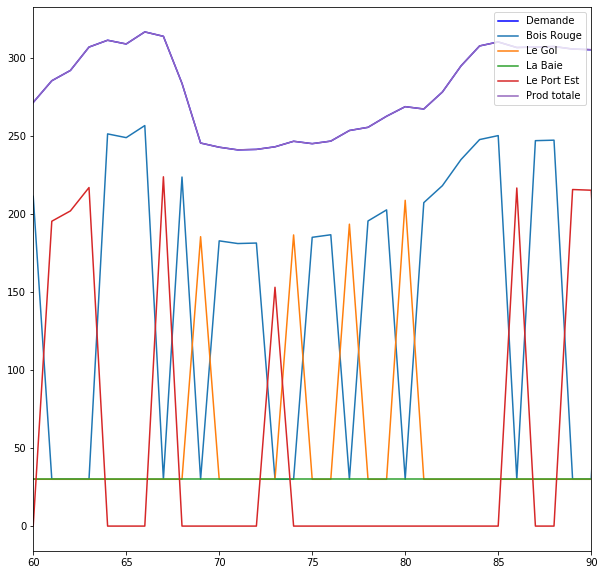

In [57]:
display_results(True)